# Notebook 0: Exploratory Data Analysis

In [2]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import sys
import os
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import entropy
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

from epic_clustering.utils import plot_clusters, get_cluster_pos

## Roadmap

Our plan is to load some data and visualize the various features that are included in the dataset.

## 1. Load a CSV file

First, we load one of the CSV files. The exact way you do this will differ between a local notebook and a Kaggle notebook.

In [3]:
input_dir = "/global/cfs/cdirs/m3443/data/PowerWeek/train/train"
csv_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')]

In [4]:
events = pd.read_csv(csv_files[0])

## 2. Initial Inspection

Let's examine the dataframe and see what is available.

In [5]:
events.head()

,event,hit_number,N,E,T,ix,iy,iz,posx,posy,posz,clusterID,Efrac,uniqueID
0,27000,0,1895,0.261049,17.51,82,60,0,117.543274,27.425,365.28,11509158343811193875,1.0,-6937585729898357741
1,27000,1,1895,1.218229,12.57,38,42,0,-82.629840,-62.575,363.28,17828652613631594586,1.0,-618091460077957030
2,27000,2,1895,0.983161,12.61,38,43,0,-82.629840,-67.425,365.28,17828652613631594586,1.0,5343361554445887269
3,27000,3,1895,0.404564,12.57,45,42,0,-77.370160,-62.575,361.28,17828652613631594586,1.0,-7175626205880516806
4,27000,4,1895,0.393017,13.46,39,43,1,-87.543280,-67.425,383.28,17828652613631594586,1.0,-3965530794151426912


## 3. Visualize Distributions

It's usually very useful to understand the histogrammed distribution of the features in the dataset. This helps with feature engineering, and gaining some physical intuition about how to further visualize combinations of features.

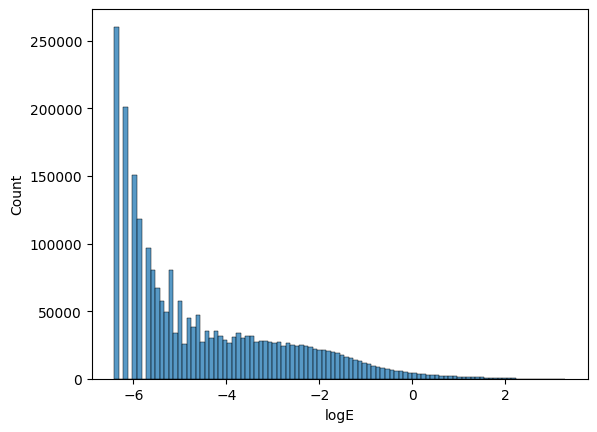

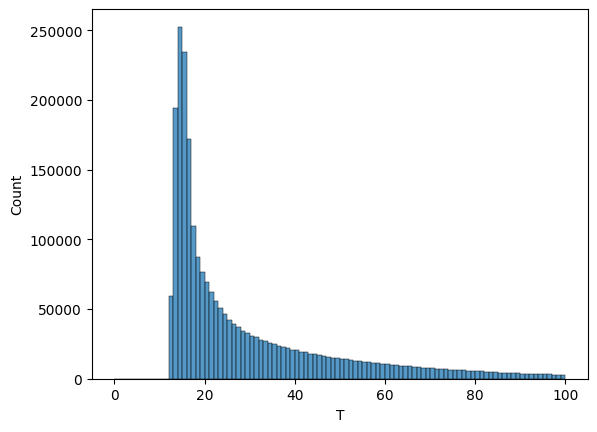

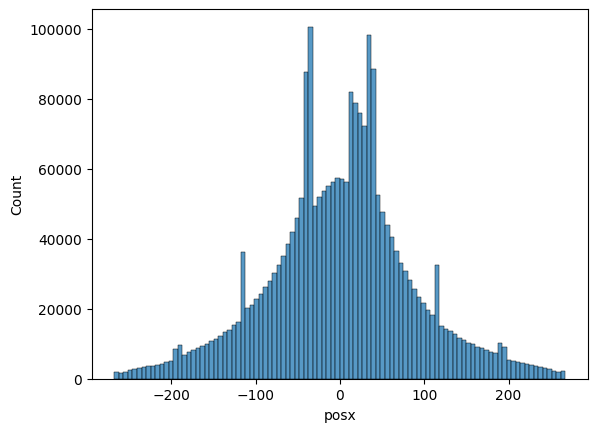

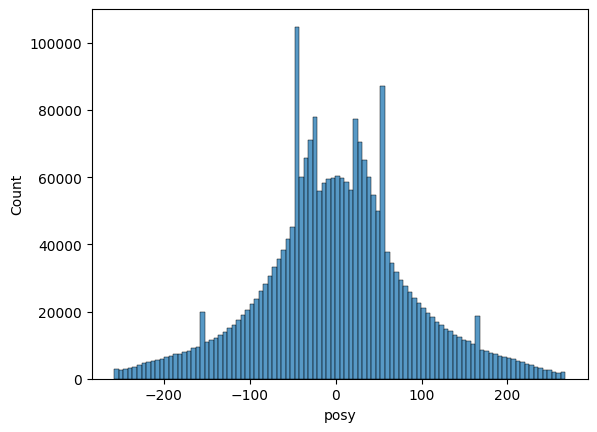

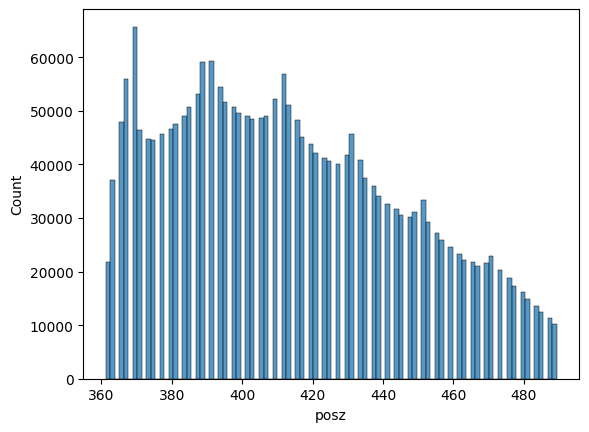

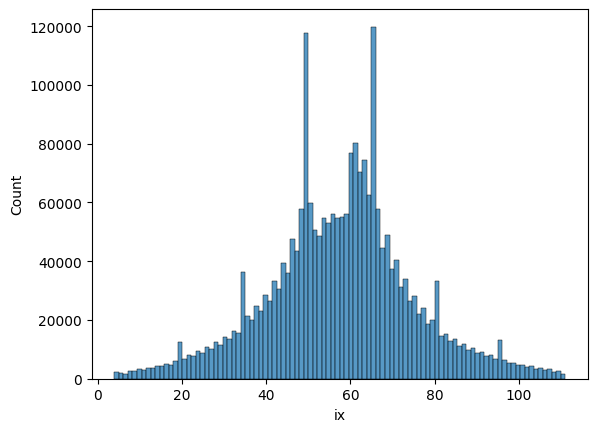

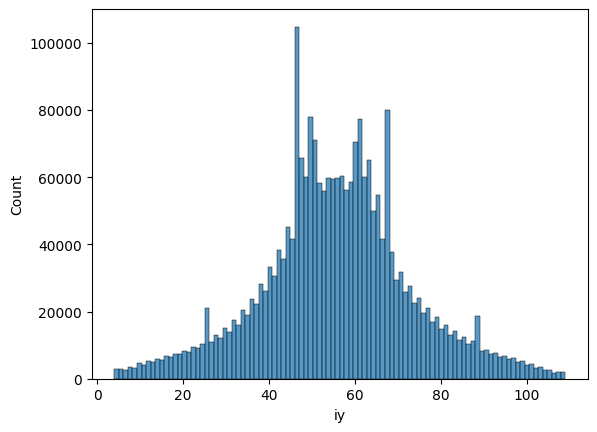

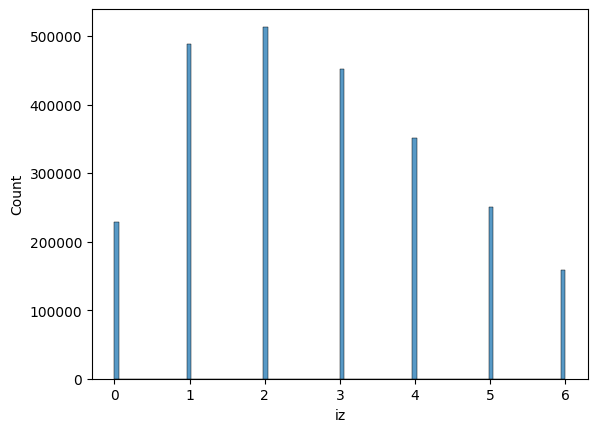

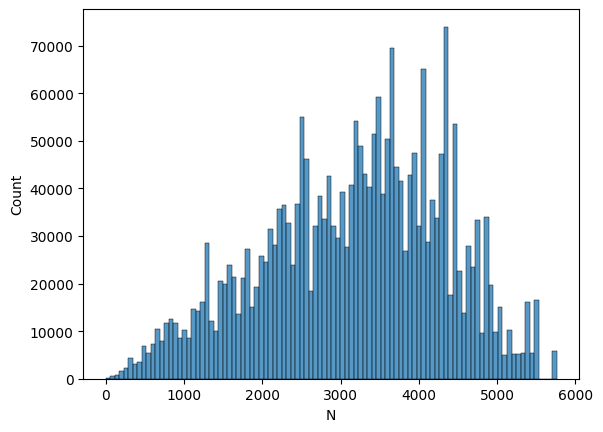

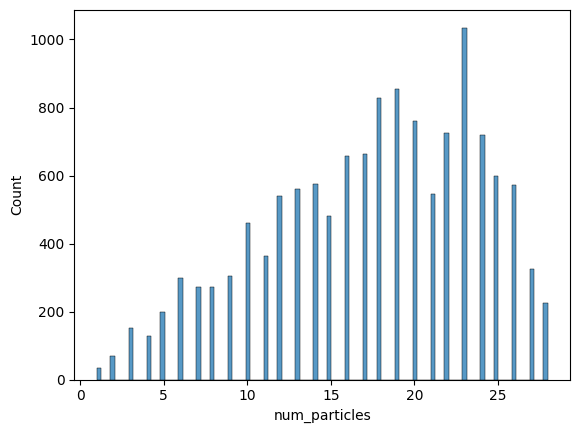

In [7]:
# Make sns histogram of each variable
# Add a column to count the number of clusters in each event, grouped by clusterID
events["num_particles"] = events.drop_duplicates(subset=["clusterID"]).groupby("event")["event"].transform("count")
events["logE"] = np.log(events["E"])
columns_to_histogram = ["logE", "T", "posx", "posy", "posz", "ix", "iy", "iz", "N", "num_particles"]
for column in columns_to_histogram:
    sns.histplot(events[column], bins=100)
    plt.show()

We can make some initial observations about this data...
- The (x,y) plane is bounded by (-270, 270)
- The energy distribution is a long-tail, with most of the hits having a **tiny** amount of energy, and a few hits having a **huge** amount of energy
- A typical event has 3000 - 4000 hits (i.e. energy deposits)
- A typical event has 15 - 25 particles involved in leaving energy deposits
- The time distribution is also a long-tail, with most of the hits being left in the first 20 nanoseconds (adjusted with the offset)
- There is a quirky asymmetry in the x distribution - this is covered in the calorimeter slides!

## 4. Visualize some events in 2D space

Let's build up a visualization in an iterative way, using the above observations. First, let's select an event that has an average number of hits and particles, using the above distribution. 

In [14]:
typical_events = events[(events["N"] > 3000) & (events["N"] < 4000) & (events["num_particles"] > 15) & (events["num_particles"] < 25)]
typical_event = events[events["event"] == typical_events.iloc[0]["event"]]

In [22]:
typical_event

,event,hit_number,N,E,T,ix,iy,iz,posx,posy,posz,clusterID,Efrac,uniqueID,num_particles,logE
1895,27001,0,3963,2.341605,13.33,93,50,0,162.62984,-22.575,367.28000,9958641657352869518,1.0,-8488102416356682098,20.0,0.850837
1896,27001,1,3963,2.092928,16.13,94,51,4,197.37016,-27.425,443.27997,9958641657352869518,1.0,-3297620686144080811,NaN,0.738564
1897,27001,2,3963,1.532065,13.60,92,50,1,167.54327,-22.575,377.28000,9958641657352869518,1.0,-3144952269302828998,NaN,0.426616
1898,27001,3,3963,1.391849,16.05,95,50,4,192.45673,-22.575,439.27997,9958641657352869518,1.0,-1570202826219224247,NaN,0.330633
1899,27001,4,3963,1.351021,15.98,95,51,4,192.45673,-27.425,439.27997,9958641657352869518,1.0,-9074326880881026657,NaN,0.300861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5853,27001,3958,3963,0.001650,43.14,45,74,4,-77.37016,97.425,431.27997,12249417173565187742,1.0,-3030503557574130016,NaN,-6.407223
5854,27001,3959,3963,0.001650,16.72,39,79,3,-87.54328,112.575,423.27997,12249417173565187742,1.0,-6691282978773846071,NaN,-6.407223
5855,27001,3960,3963,0.001650,20.09,51,73,3,-47.37016,82.575,423.27997,12249417173565187742,1.0,1651169675047815720,NaN,-6.407223
5856,27001,3961,3963,0.001650,37.03,46,68,4,-62.45672,67.425,443.27997,12249417173565187742,1.0,3887486180240906581,NaN,-6.407223


Now, we understand the bounds of the (x,y) plane, so we can plot this

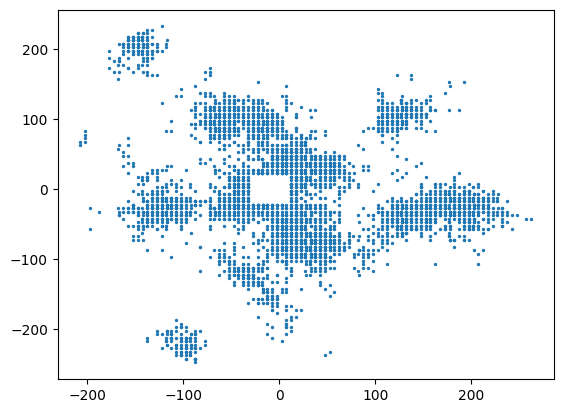

In [27]:
plt.scatter(typical_event.posx, typical_event.posy, s=2)

We also know that we have energy as a feature, and **it is a feature that is going to be used as a measure of importance in the scoring function**. So, let's use energy as an opacity for the points. We see that it has a long tail, so let's take the square root to more clearly see the clusters. (Try plotting the energy directly to see how sparse the clusters are!)

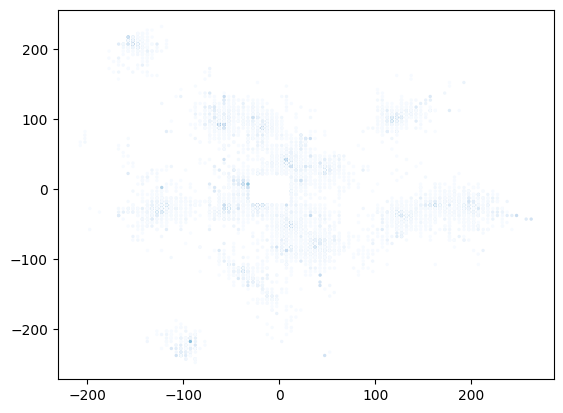

In [35]:
plt.scatter(typical_event.posx, typical_event.posy, s=2, cmap="Blues", c=np.sqrt(typical_event.E))

We see that there are not **so** many particles in each event, so we can color-code them without completely losing the thread of what is going on.

In the above Z-distribution, we clearly see that deposits are localized around each of the X layers in the z-direction. We can therefore visualize our hits in the (x,y) plane for each of the X layers. 

## 5. Visualize some events in 3D space

In 2D, the clusters are clearly visible, and we may even be able to identify some of them by eye. This is a good clue about where to start with our initial clustering algorithm. Let's see if we can do better by visualizing in 3D.

I don't know about you, but it's **harder** to visualize clusters in 3D. This is not just human error, but a real effect - the distance between clusters on a given layer is around the same as between layers. This means that if we naively apply a clustering algorithm, it will probably cluster by both particle and layer. This is okay, provided we then use the layer information to reconstruct the particles.